In [1]:
%load_ext autoreload
%autoreload 2
from pkg.forecast import SalesForecast
import pandas as pd
import os
import csv

Importing plotly failed. Interactive plots will not work.


In [2]:
sale = 'data/sales/monthly_sales.csv'
forecasts = 'data/results/Forecasts test.csv'
headers=['product', 'date', 'forecast', 'model']
if not os.path.exists(forecasts):
    with open(forecasts, "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
sale_df_total = pd.read_csv(sale)
forecast_df = pd.read_csv(forecasts)

products_fr = pd.unique(forecast_df['product'])
products = pd.unique(sale_df_total['product'])
sale_df_total.date += 62100

In [13]:
sale_df = sale_df_total[sale_df_total['product'] == "Alvopax 30"]
prod_fr = SalesForecast("Alvopax 30", sale_df, forecasts)
prod_fr.preprocess_data()
prod_fr.model_selection()

In [16]:
# prod_fr.best_model_type = "Prophet"
prod_fr.predict()
prod_fr.redistribute_smoothing()

In [14]:
pd.set_option('display.max_rows', None)
print(prod_fr.forecast)

None


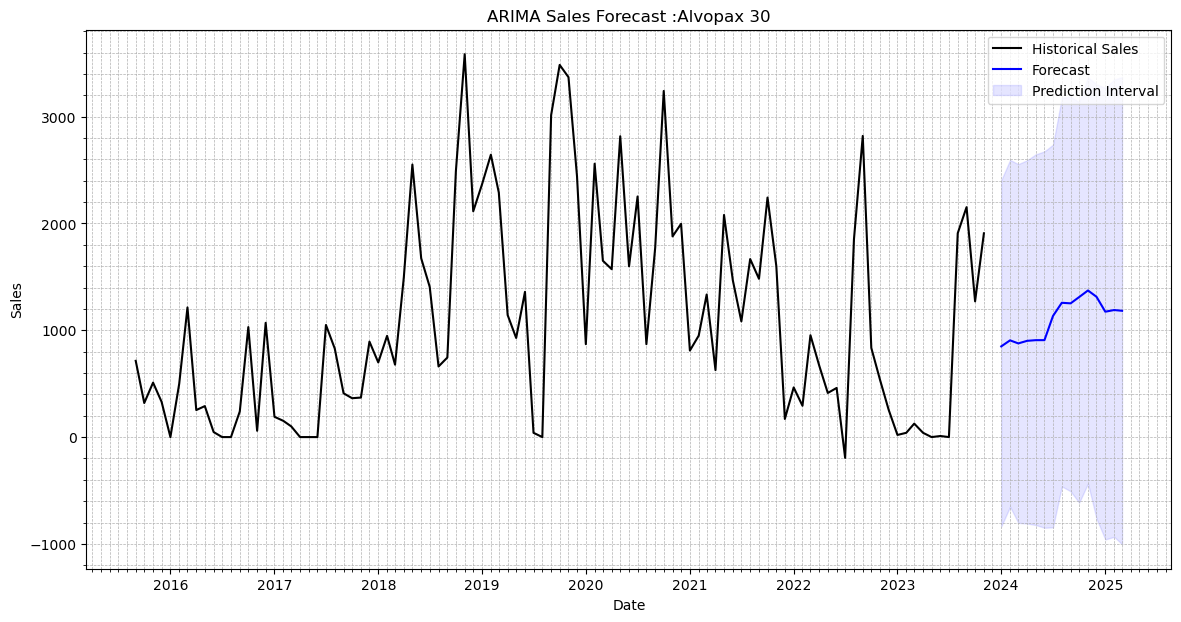

In [17]:
prod_fr.plot()